# <font style="color:blue">PyTorch to PyTorch Lightning (with LeNet)</font>

---

In this notebook, we will re-implement  [`Implementing LeNet in PyTorch`](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/41758fee84fa4f95be0a9b22403b1748/d44a2e71798d4e26909d30575c742506/2?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%405d3e4e9657184e21888c5ade002a8d5b) notebook in PyTorch Lightning. We will be mostly focused on implementation. We will cover the following in PyTorch Lightning:

1. Model in PyTorch Lightning (`LightningModule`)
2. Training step
3. Validation step
4. Metrics
5. Optimizer configuration
6. Data Module (`LightningDataModule`)
7. Hyperparameters
8. Tensorboard logs
9. Saving and loading the model
10. Trainer


We will see how the PyTorch code is re-factored to PyTorch Lightning. 

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  

In [3]:
# import pytorch lightning
import pytorch_lightning as pl

# import pre-implemented accuracy metrics 
from pytorch_lightning.metrics.functional import accuracy

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

## <font style="color:green">1. Lightning Module</font>

---

We create a class with `LightningModule` as a base class. This class should have the model, training step, validation step, optimizer, etc. A `LightningModule` organizes a model training code as follows:

In [4]:
class LeNet5(pl.LightningModule):  # here nn.Module is replaced by LightningModule
    def __init__(self, learning_rate=0.01):
        super().__init__()
        
        # Save the arguments as hyperparameters. 
        self.save_hyperparameters()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),
            
            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer. It is also the output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )
        

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x
    
    def training_step(self, batch, batch_idx):
        
        # get data and labels from batch
        data, target = batch

        # get prediction
        output = self(data)
        
        # calculate loss
        loss = F.cross_entropy(output, target)
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]
        
        acc = accuracy(pred=pred, target=target)
        
        
        dic = {
            'train_loss': loss,
            'train_acc': acc
        }
        

        return {'loss': loss, 'log': dic, 'progress_bar': dic}

    def training_epoch_end(self, training_step_outputs):
        # training_step_outputs = [{'loss': loss, 'log': dic, 'progress_bar': dic}, ..., 
        #{'loss': loss, 'log': dic, 'progress_bar': dic}]
        avg_train_loss = torch.tensor([x['progress_bar']['train_loss'] for x in training_step_outputs]).mean()
        avg_train_acc = torch.tensor([x['progress_bar']['train_acc'] for x in training_step_outputs]).mean()
        
        
        dic = {
            'epoch_train_loss': avg_train_loss,
            'epoch_train_acc': avg_train_acc
        }
        return {'log': dic, 'progress_bar': dic}
        
    
    def validation_step(self, batch, batch_idx):
        
        # get data and labels from batch
        data, target = batch
        
        # get prediction
        output = self(data)
        
        # calculate loss
        loss = F.cross_entropy(output, target)
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]
        
        acc = accuracy(pred=pred, target=target)
        
        dic = {
            'v_loss': loss,
            'v_acc': acc
        }
        
        return dic
    
    
    def validation_epoch_end(self, validation_step_outputs):
        # validation_step_outputs = [dic, ..., dic]
        
        avg_val_loss = torch.tensor([x['v_loss'] for x in validation_step_outputs]).mean()
        avg_val_acc = torch.tensor([x['v_acc'] for x in validation_step_outputs]).mean()
        
        
        dic = {
            'avg_val_loss': avg_val_loss,
            'avg_val_acc': avg_val_acc
        }
        return {'val_loss': avg_val_loss, 'log': dic, 'progress_bar': dic}
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)

### <font style="color:green">1.1. Model definition and forward method</font>

In PyTorch Lightning, model definition and forward method are similar to PyTorch. The only difference is the base class. In PyTorch, the base class is `torch.nn.module`; however, in PyTorch Lightning, the base class is `pytorch_lightning.LightningModule`.


In PyTorch Lightning, we are using an extra argument `learning_rate` and the following line of code:

```python
# Save the arguments as hypermeters. 
self.save_hyperparameters()
```

The above line of code saves arguments as hyperparameters. 

### <font style="color:green">1.2. Training loop (training_step)</font>

**Model training in Pytorch requires a loop that iterates through the training dataset using a batch size and does some fix operations with each batch**. <br>
In PyTorch Lighting, we need to write those fix operations except the optimization step. These fixed operations should be defined under the `training_step` method of the same class where the model is defined. The "training_step" is mandatory in PyTorch Lightning. If there is no `validatioion_step` (not mandatory with `LightningModule`), the model checkpoint will be saved when training loss decreases. 


**Let's compare operations on each batch in PyTorch code and training_step of PyTorch Lightning code.**


**PyTorch code:**

```python
        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

```

**PyTorch Lightning code:**

```python
    def training_step(self, batch, batch_idx):
        
        # get data and labels from batch
        data, target = batch

        # get prediction
        output = self(data)
        
        # calculate loss
        loss = F.cross_entropy(output, target)
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]
        
        acc = accuracy(pred=pred, target=target)
        
        
        dic = {
            'train_loss': loss,
            'train_acc': acc
        }
        

        return {'loss': loss, 'log': dic, 'progress_bar': dic}
```


- Model inference, loss calculation, and class prediction are the same in both. 


- For accuracy calculation (`accuracy(pred=pred, target=target)`), PyTorch Lightning metric module is being used. Get details of metrics [here](https://pytorch-lightning.readthedocs.io/en/latest/metrics.html).


- Calculate gradient (`loss.backward()`) and update weights (`optimizer.step()`), are there in PyTorch code but not in `training_step` of PyTorch Lightning. How is PyTorch Lightning handling the gradient calculation and gradient of what? The `training_step` is returning `{'loss': loss, 'log': dic, 'progress_bar': dic}`, here by default, it is mandatory to have a key with name loss and internally Lightning access the graph (`loss` here) by the key "loss" and calculate the gradients of the graph with respect to parameters and update it in each batch.


- There are two arrays (`batch_loss`, `batch_acc`) in PyTorch code, for batch loss and accuracy collection. Later these arrays are used to calculate mean epoch loss and accuracy. These are taken care of by the `training_epoch_end` method in PyTorch Lightning.


- The `training_step` method is returning `{'loss': loss, 'log': dic, 'progress_bar': dic}`. We have already discussed the significance of the key "loss". What is the significance of the key "log" and "progress_bar"? The key "log" is used for logging (by default tensorboard). And the key "progress_bar" is used to add key-value to the progress bar while training.




### <font style="color:green">1.3. Validation loop (validation_step)</font>

Generally, we use a validation loop to evaluate our model and save the model checkpoint if performance improves. In PyTorch Lightning, we use `validation_step` to accomplish the same task. By default, the model checkpoint got saved if the validation loss decreases.


**Let's compare operations on each batch in PyTorch code and validation_step of PyTorch Lightning code.**


**PyTorch code:**

```python

        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()
```

**PyTorch Lightning code:**


```python
    def validation_step(self, batch, batch_idx):
        
        # get data and labels from batch
        data, target = batch
        
        # get prediction
        output = self(data)
        
        # calculate loss
        loss = F.cross_entropy(output, target)
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]
        
        acc = accuracy(pred=pred, target=target)
        
        dic = {
            'v_loss': loss,
            'v_acc': acc
        }
        
        return dic
    
```


- Operations in the validation loop in PyTorch code are almost similar to the validation_step in PyTorch Lightning code.


- The validation_step returns a dictionary of loss and accuracy. This will be used by validation_epoch_end to calculate epoch loss and accuracy and add it to logs and progress bar.


### <font style="color:green">1.4. training_epoch_end</font>

This is a method of `LightningModule`. As the name suggests, this function will be called after each training epoch. Training epoch loss and accuracy is needed for logs and plots. We can handle these things here.

**PyTorch Lightning code:**

```python
    def training_epoch_end(self, training_step_outputs):
        # training_step_outputs = [{'loss': loss, 'log': dic, 'progress_bar': dic}, ..., 
        #{'loss': loss, 'log': dic, 'progress_bar': dic}]
        avg_train_loss = torch.tensor([x['progress_bar']['train_loss'] for x in training_step_outputs]).mean()
        avg_train_acc = torch.tensor([x['progress_bar']['train_acc'] for x in training_step_outputs]).mean()
        
        
        dic = {
            'epoch_train_loss': avg_train_loss,
            'epoch_train_acc': avg_train_acc
        }
        return {'log': dic, 'progress_bar': dic}
```


### <font style="color:green">1.5. validation_epoch_end</font>

This is a method of `LightningModule` that is responsible for saving of model checkpoint. By default, if the validation loss decreases, the model checkpoint used to be saved.

**PyTorch Lightning code:**

```python
    def validation_epoch_end(self, validation_step_outputs):
        # validation_step_outputs = [dic, ..., dic]
        
        avg_val_loss = torch.tensor([x['v_loss'] for x in validation_step_outputs]).mean()
        avg_val_acc = torch.tensor([x['v_acc'] for x in validation_step_outputs]).mean()
        
        
        dic = {
            'avg_val_loss': avg_val_loss,
            'avg_val_acc': avg_val_acc
        }
        return {'val_loss': avg_val_loss, 'log': dic, 'progress_bar': dic}
```


### <font style="color:green">1.6. configure_optimizers</font>


This method of `LightningModule` is used to define the optimizers. 

**PyTorch code:**

```python
    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )
```

**PyTorch Lightning code:**

```python
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)
```

## <font style="color:green">2. Lightning Data Module</font>

**A Lightning data module encapsulates the five steps involved in data processing in PyTorch:**

1. Download
2. Clean and save data
3. Load inside [dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
4. Apply transforms
5. Wrap inside [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)


**Why should we use the Lightning data module?**

The Lightning data module forces us to do data processing (downloading to PyTorch dataloader)  in a single class. It has a pre-defined name for a specific task. It makes it easy to understand, reuse, and share. 


We can replace the `get_data` method in PyTorch implementation with the `MNISTDataModule` class in PyTorch Lightning implementation that is more abstract and intuitive. All operations related to data can be defined in the same class, for example, data augmentation, mean-std calculation, etc.

In [5]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, data_root, batch_size, num_workers):
        
        super().__init__()
        
        self.data_root = data_root
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        self.train_test_transforms = transforms.Compose([
            # Resize to 32X32
            transforms.Resize((32, 32)),
            # this re-scales image tensor values between 0-1. image_tensor /= 255
            transforms.ToTensor(),
            # subtract mean (0.1307) and divide by variance (0.3081).
            # This mean and variance is calculated on training data (verify for yourself)
            transforms.Normalize((0.1307, ), (0.3081, ))
        ])
        
    def prepare_data(self):
        # download
        datasets.MNIST(self.data_root, train=True, download=True)
        datasets.MNIST(self.data_root, train=False, download=True)
        
    def setup(self, stage=None):
        
        self.train_dataset = datasets.MNIST(self.data_root, train=True, transform=self.train_test_transforms)
        self.val_dataset = datasets.MNIST(self.data_root, train=False, transform=self.train_test_transforms)
    


    def train_dataloader(self):
        # train loader
        train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=self.num_workers
        )
        return train_loader

    def val_dataloader(self):
        # validation loader
        test_loader = torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers
        )
        return test_loader

**Pre-defined methods and their usages are as follows:**

- **`prepare_data`:** This method is used for data preparation. For example, downloading and doing one time preprocessing with the dataset. If one is training on distributed GPU, this will be called from a single GPU. So do not update or initiate attributes in this method (Note: Do not do - `self.x = y`)


- **`setup`:** There are also data operations one might want to perform on every GPU. For example, perform train/val/test splits. This method will be called from every GPU. 


- **`train_dataloader`:** This method should return dataloader with train dataset. 


- **`val_dataloader(s)`:** This method should return dataloader(s) with validation dataset.


- **`test_dataloader(s)`:** This method should return dataloader(s) with test dataset.


Get details of `LightningDataModule` [here](https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html).

## <font style="color:green">3. Hyperparameters</font>

PyTorch Lightning has a default CLI (command line interface), and more arguments can be added using `ArgumentParser`. A few examples of default arguments are `--gpus`, `--deterministic`, `--max_epochs`, etc.

Lightning is also compatible with hyperparameters optimization framework, eg. [optuna](https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py), [ray tune](https://docs.ray.io/en/master/tune/tutorials/tune-pytorch-lightning.html), etc.


**The configuration code of PyTorch implementation can be defined using default arguments of argument parser.**

In [6]:
from argparse import ArgumentParser

def configuration_parser(parent_parser):
    parser = ArgumentParser(parents=[parent_parser], add_help=False)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--epochs_count', type=int, default=20)
    parser.add_argument('--data_root', type=str, default='data')
    parser.add_argument('--num_workers', type=int, default=10)
    parser.add_argument('--learning_rate', type=float, default=0.01)
    return parser




We can notice that `configuration_parser` has an argument `parent_parser`. As the name suggests, it is an argument parser, and in this method, we are adding more argument to it. This argument parser already has arguments from Trainer (will see next what is a Trainer) class.

## <font style="color:green">4. Trainer</font>

Once we have organized the PyTorch code with LightningModule and LightningDataModule, the Trainer automates everything else. 

**PyTorch code abstraction via PyTorch Lightning has the following advantages:**

1. We have control over the code without an added abstraction.
2. The PyTorch Lightning Trainer's default parameters are added by contributors and users from top AI labs such as Facebook AI Research, NYU, MIT, Stanford, etc.
3. There is the flexibility to override the default parameters of Trainer with new or none to automate with the new method or stop automation. 


**`training_validation` is a wrapper of training steps using the Trainer.**

In [3]:
def training_validation():
    
    # random seed
    pl.seed_everything(21)
    
    # initiate the argument parser
    parser = ArgumentParser()
    
    # initiates Trainer and gets already added arguments in the Trainer
    parser = pl.Trainer.add_argparse_args(parser)

    # adds more arguments to the argumennt parser
    parser = configuration_parser(parser)
    
    
    # using "parse_known_args" to work argument parser in the notebook. 
    # For normal python file we can use "parse_args"
    # args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    # print(args)

    # init model
    model = LeNet5(learning_rate=args.learning_rate)
    
    # init the data module
    data_module = MNISTDataModule(data_root=args.data_root,
                                  batch_size=args.batch_size, 
                                  num_workers=args.num_workers)
    

    # To take argument form command line, initiate the trainer like below
    trainer = pl.Trainer.from_argparse_args(args,
    #  fast_dev_run=True,  # use to test the code pipeline
    max_epochs=20,        # maximum number of epoch
    deterministic=True,  # to make code reproducible
    gpus=1,               # total number of GPUs
    progress_bar_refresh_rate=25, 
    early_stop_callback=True) # stop training if validation loss does 
    # not decrease for 3 epochs (default)
    
    
    # if one is not interested in command line argument, the Trainer can be initiated as follows:
    # trainer = pl.Trainer (
    # fast_dev_run=True,
    # max_epochs=20,
    # deterministic=True,
    # gpus=1,
    # progress_bar_refresh_rate=25,
    # early_stop_callback=True)
    
    
    # start training
    trainer.fit(model, data_module)
    
    return model, data_module

When you download files from the download code section, we will also get the same notebook in .py format. You can run the python file in the command line.

**Run the following command to get all arguments options**
```
python PyTorch_to_Lightning.py -h
```

You will get the following options:

```
usage: PyTorch_to_Lightning.py [-h] [--logger [LOGGER]]
                               [--checkpoint_callback [CHECKPOINT_CALLBACK]]
                               [--early_stop_callback [EARLY_STOP_CALLBACK]]
                               [--default_root_dir DEFAULT_ROOT_DIR]
                               [--gradient_clip_val GRADIENT_CLIP_VAL]
                               [--process_position PROCESS_POSITION]
                               [--num_nodes NUM_NODES]
                               [--num_processes NUM_PROCESSES] [--gpus GPUS]
                               [--auto_select_gpus [AUTO_SELECT_GPUS]]
                               [--tpu_cores TPU_CORES]
                               [--log_gpu_memory LOG_GPU_MEMORY]
                               [--progress_bar_refresh_rate PROGRESS_BAR_REFRESH_RATE]
                               [--overfit_batches OVERFIT_BATCHES]
                               [--track_grad_norm TRACK_GRAD_NORM]
                               [--check_val_every_n_epoch CHECK_VAL_EVERY_N_EPOCH]
                               [--fast_dev_run [FAST_DEV_RUN]]
                               [--accumulate_grad_batches ACCUMULATE_GRAD_BATCHES]
                               [--max_epochs MAX_EPOCHS]
                               [--min_epochs MIN_EPOCHS]
                               [--max_steps MAX_STEPS] [--min_steps MIN_STEPS]
                               [--limit_train_batches LIMIT_TRAIN_BATCHES]
                               [--limit_val_batches LIMIT_VAL_BATCHES]
                               [--limit_test_batches LIMIT_TEST_BATCHES]
                               [--val_check_interval VAL_CHECK_INTERVAL]
                               [--log_save_interval LOG_SAVE_INTERVAL]
                               [--row_log_interval ROW_LOG_INTERVAL]
                               [--distributed_backend DISTRIBUTED_BACKEND]
                               [--sync_batchnorm [SYNC_BATCHNORM]]
                               [--precision PRECISION]
                               [--weights_summary WEIGHTS_SUMMARY]
                               [--weights_save_path WEIGHTS_SAVE_PATH]
                               [--num_sanity_val_steps NUM_SANITY_VAL_STEPS]
                               [--truncated_bptt_steps TRUNCATED_BPTT_STEPS]
                               [--resume_from_checkpoint RESUME_FROM_CHECKPOINT]
                               [--profiler [PROFILER]]
                               [--benchmark [BENCHMARK]]
                               [--deterministic [DETERMINISTIC]]
                               [--reload_dataloaders_every_epoch [RELOAD_DATALOADERS_EVERY_EPOCH]]
                               [--auto_lr_find [AUTO_LR_FIND]]
                               [--replace_sampler_ddp [REPLACE_SAMPLER_DDP]]
                               [--terminate_on_nan [TERMINATE_ON_NAN]]
                               [--auto_scale_batch_size [AUTO_SCALE_BATCH_SIZE]]
                               [--prepare_data_per_node [PREPARE_DATA_PER_NODE]]
                               [--amp_type AMP_TYPE] [--amp_level AMP_LEVEL]
                               [--val_percent_check VAL_PERCENT_CHECK]
                               [--test_percent_check TEST_PERCENT_CHECK]
                               [--train_percent_check TRAIN_PERCENT_CHECK]
                               [--overfit_pct OVERFIT_PCT]
                               [--batch_size BATCH_SIZE]
                               [--epochs_count EPOCHS_COUNT]
                               [--data_root DATA_ROOT]
                               [--num_workers NUM_WORKERS]
                               [--learning_rate LEARNING_RATE]

```

**You can notice that we have added the last five options.**

**To train with 16-bit precision, run the following command:**

```
python PyTorch_to_Lightning.py --precision 16
```

Note that we can not update `max_epochs`, `deterministic`, `gpus`, etc. flags via command line, because we have overridden it.

Get more details [here](https://pytorch-lightning.readthedocs.io/en/latest/trainer.html)

### <font style="color:green">Tensorboard Dashboard</font>

In [ ]:
# To reload tensorBoard
%load_ext tensorboard

# logs folder path
%tensorboard --logdir=lightning_logs

**Let's start training.**

In [9]:
model, data_module = training_validation()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | _body | Sequential | 2 K   
1 | _head | Sequential | 59 K  


Epoch 00012: early stopping triggered.


## <font style="color:green">5. Model Loading and Inference</font>

The `sample_prediction` method takes `model`, `data_module`, and `ckpt_path` as arguments. Load the checkpoint from given `ckpt_path`. Get validation data loader from the `data_module` and make inference on one batch and plot them. 

In [10]:
def sample_prediction(model, data_module, ckpt_path):
    
    # load model from checkpoint
    ckpt_model = model.load_from_checkpoint(ckpt_path)
    # freeze model for inference
    ckpt_model.freeze()
    
    # get val_dataloader for data_module
    val_data = data_module.val_dataloader()
    
    for data, _ in val_data:
        output = model(data)

        # get probability score using softmax
        prob = F.softmax(output, dim=1)

        # get the max probability
        pred_prob = prob.data.max(dim=1)[0]
    
        # get the index of the max probability
        pred_index = prob.data.max(dim=1)[1]
        # pass the loaded model
        pred, prob = pred_index.cpu().numpy(), pred_prob.cpu().numpy()
        break
    

    plt.rcParams["figure.figsize"] = (3, 3)
    for images, _ in val_data:
        for i, img in enumerate(images):
            img = transforms.functional.to_pil_image(img)
            plt.imshow(img, cmap='gray')
            plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
            plt.show()
        break
    
    return

When we run the notebook (or the `.py`) multiple times, one version directory is created inside `lightning_logs` every time we want to run the sample on the latest model. So we have written the method `get_latest_run_version_ckpt_epoch_no` to find the checkpoint path of the latest run. 

In [11]:
import os

def get_latest_run_version_ckpt_epoch_no(lightning_logs_dir='lightning_logs', run_version=None):
    if run_version is None:
        run_version = 0
        for dir_name in os.listdir(lightning_logs_dir):
            if 'version' in dir_name:
                if int(dir_name.split('_')[1]) > run_version:
                    run_version = int(dir_name.split('_')[1])
                
    checkpoints_dir = os.path.join(lightning_logs_dir, 'version_{}'.format(run_version), 'checkpoints')
    
    files = os.listdir(checkpoints_dir)
    ckpt_filename = None
    for file in files:
        if file.endswith('.ckpt'):
            ckpt_filename = file
        
    if ckpt_filename is not None:
        ckpt_path = os.path.join(checkpoints_dir, ckpt_filename)
    else:
        print('CKPT file is not present')
    
    return ckpt_path

**Let's have sample prediction from the latest saved checkpoint.**

The latest model path: lightning_logs/version_7/checkpoints/epoch=7.ckpt


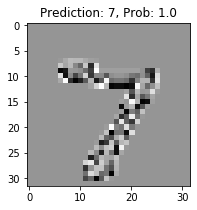

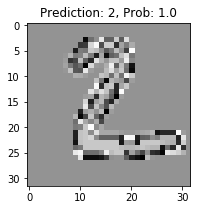

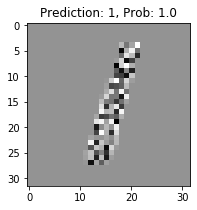

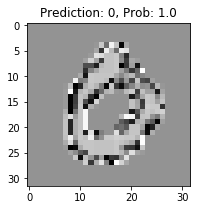

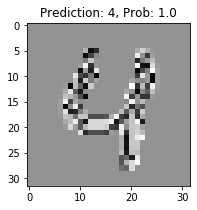

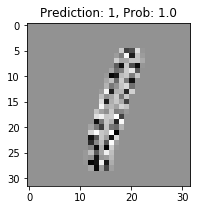

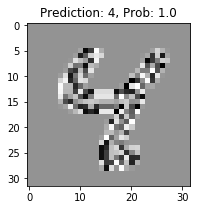

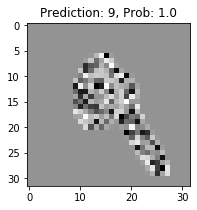

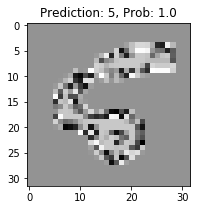

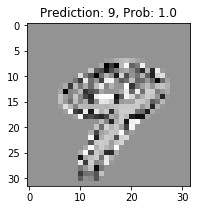

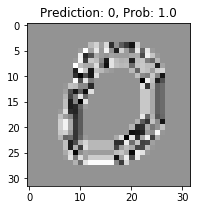

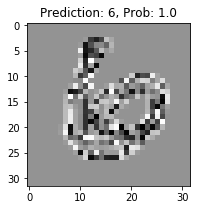

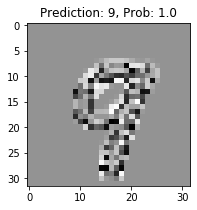

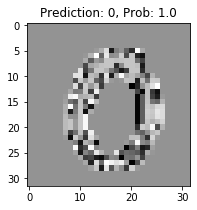

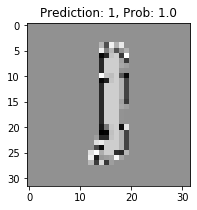

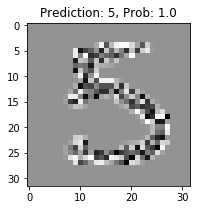

In [12]:
# get checkpoints of the latest run
ckpt_path = get_latest_run_version_ckpt_epoch_no()
print('The latest model path: {}'.format(ckpt_path))

# sample prediction
sample_prediction(model, data_module, ckpt_path)

# <font style="color:blue">References</font>

1. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
1. https://pytorch.org/tutorials/beginner/saving_loading_models.html
1. https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=gEulmrbxwaYL
1. https://pytorch-lightning.readthedocs.io
1. https://github.com/PyTorchLightning/pytorch-lightning
1. https://www.youtube.com/watch?v=QHww1JH7IDU
1. https://pytorch-lightning.readthedocs.io/en/latest/
1. https://www.youtube.com/channel/UC8m-y0yAFJpX0hRvxH8wJVw/featured